# Lithium Oven Optic 6

In [1]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
from numpy.fft import fft, ifft, fftfreq, fftshift
from scipy.integrate import simps
from scipy.interpolate import interp1d
from scipy.special import erf
from beam.beams import laserpulse
from beam.beams import laserbeam
from beam.elements import plasma
from beam.elements import optic
from beam import interactions
from ionization import ionization
from lens import profile
from lens import bessel
from lens import ray
import matplotlib.pyplot as plt
from lens import design
import numpy.ma as ma
from copy import copy
plt.style.use('notes')
%load_ext autoreload
%autoreload 2

path = '/mnt/md0/Data/rariniello/Lithium_Oven/Lithium_Oven_Optic_6/'
lam = 0.796
tau = 70
# All length units are in um

Test optic 6 is the first prototype we actually plan on making so the optics have to be defined to fit in FACET II's experimantal area but also work with our laser for testing. This notebook contains the detailed designs for the optics as well as simulations of the beam dump.

In [2]:
plasma_LO, I, z, sim_start, sim_length, pulse = design.load_plasma_design(path)

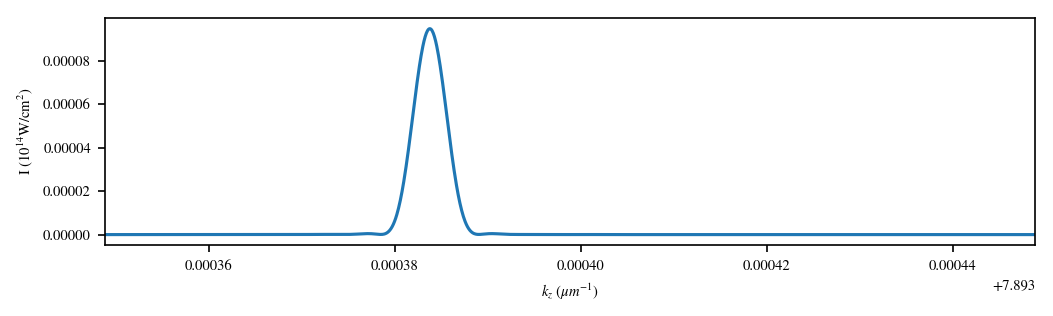

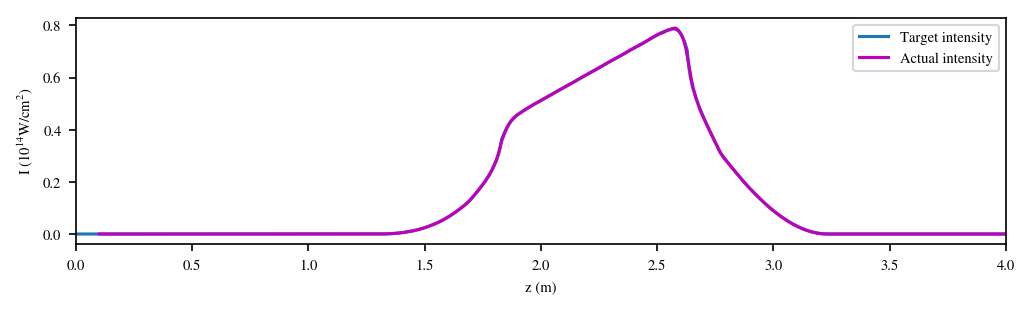

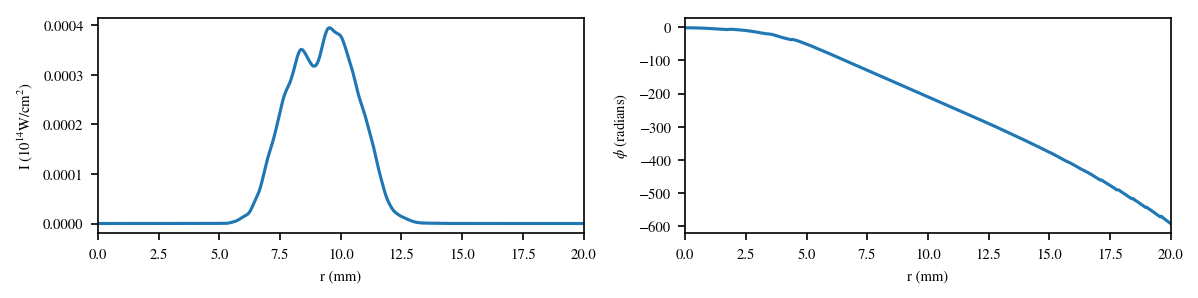

In [3]:
# Optic design upstream
width = 75
xlim = [0, 4]
z0 = 1.83075e6
z_optic, I_optic = design.extend_zI(z0, 'start', z, I, sim_start, sim_length)
I_optic *= 1
r, E = design.calculate_tran_field(z_optic, I_optic, 20e3, width, lam, path, 10e-5, xlim, [0, 20])

In [4]:
L = 0.8e6
R_max = 15e3
X = 80e3
Nx = 2**13
ri = np.linspace(0, 15e3, len(r))
Ei = np.ones(len(r))
rA, phiA, lensA, multi = design.create_lens_A(ri, Ei, r, E, L, path, lam, X, Nx)

Maximum phase change in one pixel 0.05 rad/um


Total input energy 17.74mJ


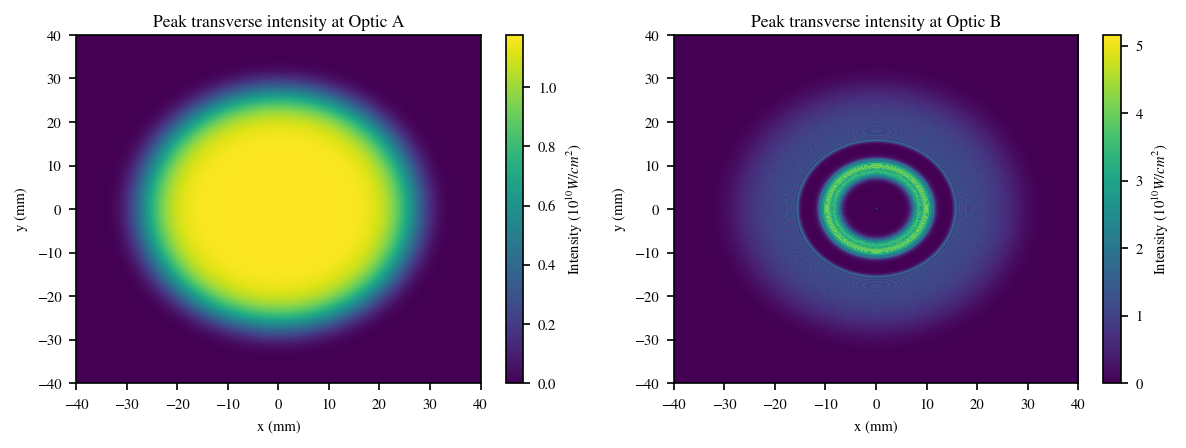

In [5]:
n = 8
w0 = 30e3
r0 = np.linspace(0, 100e3, 5000)
E0 = np.exp(-(r0/w0)**n)*multi
beam0 = design.propagate_to_lens_B(r0, E0, L, path, lam, lensA, tau, 20)

Maximum phase change in one pixel 0.30 rad/um


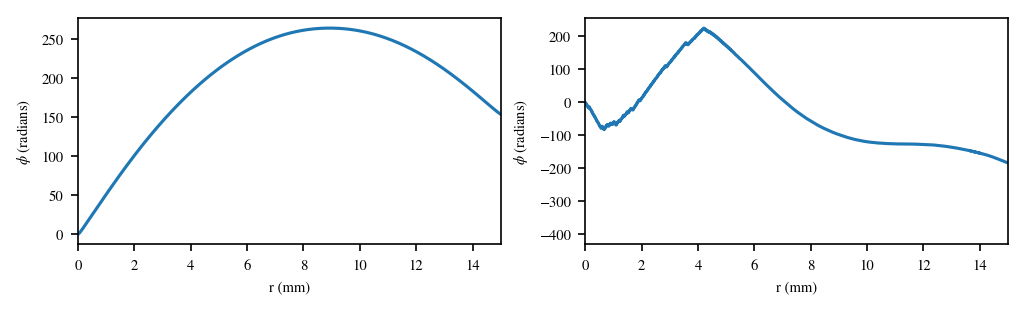

In [6]:
Nx = 2**12
X = 40e3
rB, phiB, lensB = design.create_lens_B(beam0, r, E, path, lam, X, Nx)
design.plot_phase(rA, phiA, rB, phiB, [0, 15])

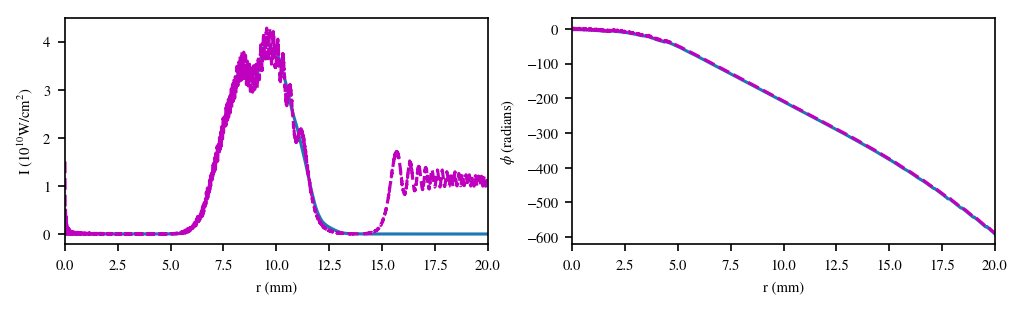

In [7]:
r1, e1 = design.field_after_lens_B(beam0, rB, phiB, r, E, [0, 20])

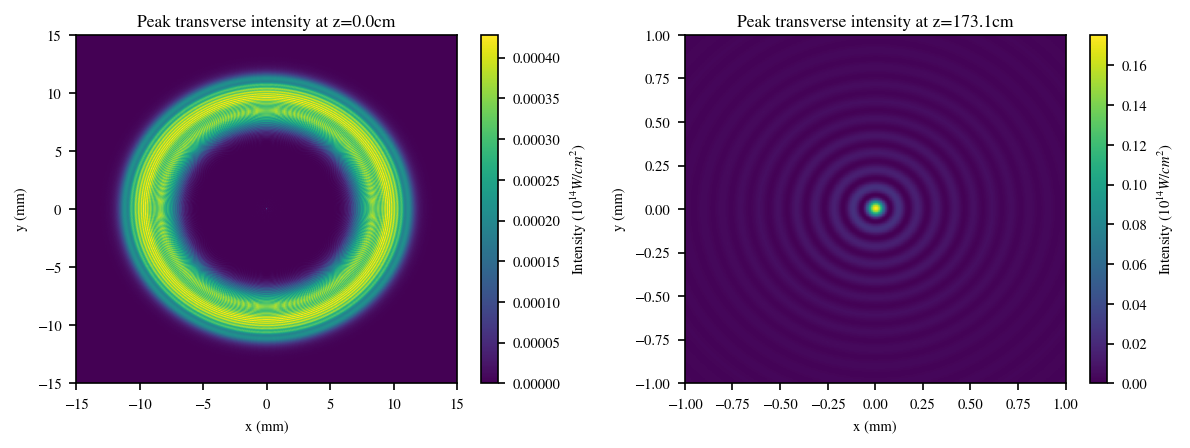

In [8]:
sel = r1 > 14e3 # Stop the outer rings from propagating
e1[sel] = 0.0
X = 30e3
Nx = 2**13
beam_start, pulseParams = design.propagate_to_start(r1, e1, z0-10e4, X, Nx, path, lam, tau, 20, [-1, 1])

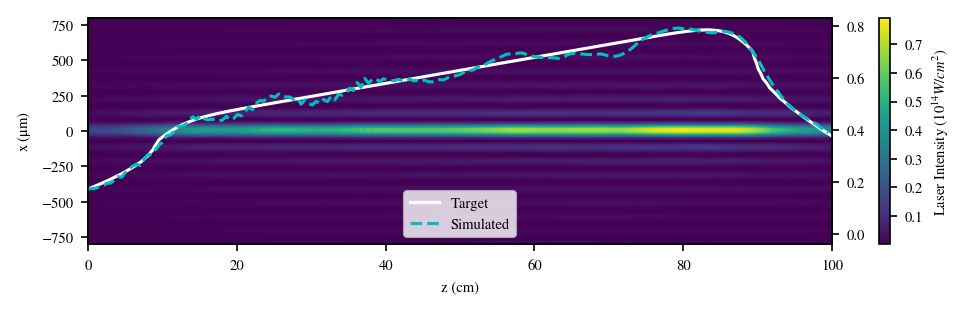

In [9]:
Nx = 2**11
Nz = 200
X = 10e3
Z = 100e4
I_0 = design.domain_test(X, Nx, Z, Nz, beam_start, pulseParams, z_optic, I_optic, z0-10e4, [-800, 800])

In [10]:
# Lens spacing tolerance study
Nz = 200
Z = 100e4
dL = np.array([-24e3, -16e3, -8e3, 0, 8e3, 16e3])
I_dL = np.zeros((len(dL), Nz, 2**11))
for i in range(len(dL)):
    beam_L = design.propagate_to_lens_B(r0, E0, L+dL[i], path, lam, lensA, tau, 20, plot=False)
    r1, e1 = design.field_after_lens_B(beam_L, rB, phiB, r, E, [0, 20], plot=False)
    sel = r1 > 14e3 # Stop the outer rings from propagating
    e1[sel] = 0.0
    X = 30e3
    Nx = 2**13
    beam_start, pulseParams = design.propagate_to_start(r1, e1, z0-10e4, X, Nx, path, lam, tau, 20, [-1, 1], plot=False)
    Nx = 2**11
    X = 10e3
    I_dL[i, :, :] = design.domain_test(X, Nx, Z, Nz, beam_start, pulseParams, z_optic, I_optic, 
                                       z0-10e4, [-800, 800], plot=False)

Total input energy 17.74mJ
Total input energy 17.74mJ
Total input energy 17.74mJ
Total input energy 17.74mJ
Total input energy 17.74mJ
Total input energy 17.74mJ


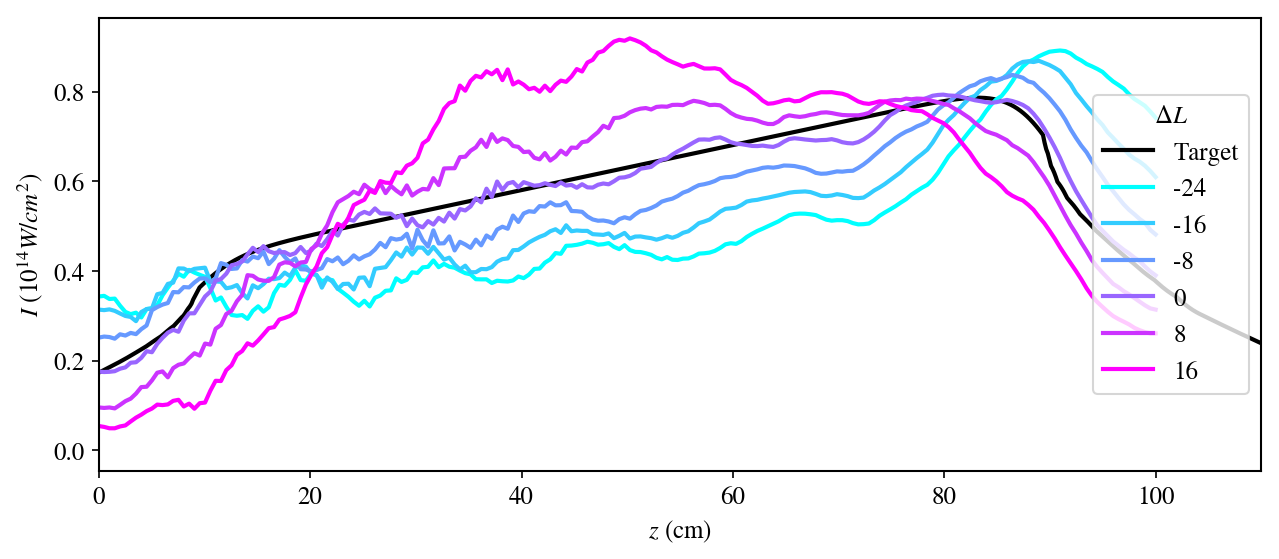

In [11]:
plt.style.use('presentation')
z = np.linspace(0, Z, Nz)
dz = z[1]-z[0]
start = z0-10e4
plt.figure(figsize=(10, 4), dpi=150)
colors = [plt.cm.cool(i) for i in np.linspace(0, 1, len(dL))]
ax = plt.subplot()
ax.set_prop_cycle('color', colors)
plt.xlabel(r'$z$ (cm)')
plt.ylabel(r'$I$ ($10^{14} W/cm^2$)')
plt.plot((z_optic-start-dz)/1e4, I_optic, 'k-', label='Target')
for i in range(len(dL)):
    plt.plot(z/1e4, I_dL[i, :, int(Nx/2)], label='%0.0f'%(dL[i]/1e3))
plt.legend(loc=7, title=r'$\Delta L$')
plt.xlim(0, Z/1e4+10)
plt.show()

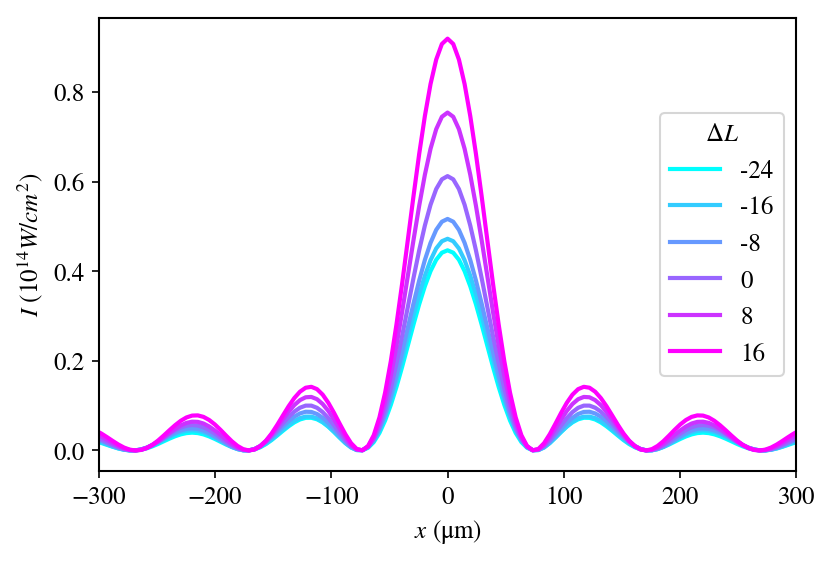

In [12]:
plt.figure(figsize=(6, 4), dpi=150)
colors = [plt.cm.cool(i) for i in np.linspace(0, 1, len(dL))]
x = np.linspace(-X/2, X/2, Nx, endpoint=False)
ax = plt.subplot()
ax.set_prop_cycle('color', colors)
plt.xlabel(r'$x$ ($\mathrm{\mu m}$)')
plt.ylabel(r'$I$ ($10^{14} W/cm^2$)')
for i in range(len(dL)):
    plt.plot(x, I_dL[i, int(Nz/2), :], label='%0.0f'%(dL[i]/1e3))
plt.legend(loc=7, title=r'$\Delta L$')
plt.xlim(-300, 300)
plt.show()
plt.style.use('notes')

In [13]:
# Calculate transverse offsets
def get_intensity(offset):
    Nx = 2**13
    X = 30e3
    Z = z0-10e4
    xlim = [-1, 1]

    pulseParams = {
        'Nt' : 2**6,
        'Nx' : Nx,
        'Ny' : Nx,
        'X' : X,
        'Y' : X,
        'T' : 3*tau,
        'lam' : lam,
        'path' : path,
        'load' : False,
        'threads' : 40,
        'cyl' : True,
        'tau' : tau,
        'name' : 'To_Start',
    }
    beam = laserbeam.Laser(pulseParams)
    e = beam.reconstruct_from_cyl(beam0.x[int(beam0.Nx/2):], beam0.e[int(beam0.Nx/2):, int(beam0.Nx/2)],beam.x, beam.y)
    phiB_2D = beam.reconstruct_from_cyl(rB, phiB, beam.x, beam.y)
    phiB_2D = np.roll(phiB_2D, offset, axis=0)
    e = e*np.exp(1j*phiB_2D)
    r_beam = np.sqrt(beam.x[:, None]**2 + beam.y[None, :]**2)
    sel = r_beam > 14e3 # Stop the outer rings from propagating
    e[sel] = 0.0
    beam.initialize_field(e)

    # Plot the initial transverse intensity
    #--------------------------------------------------------------------------
    e = beam.e
    I = beam.intensity_from_field(e)
    I = beam.prep_data(I)
    plt.figure(figsize=(10, 4), dpi=150)
    plt.subplot(121)
    plt.imshow(I, aspect='auto', extent=[-X/2e3, X/2e3, -X/2e3, X/2e3])
    cb = plt.colorbar()
    cb.set_label(r'Intensity ($10^{14} W/cm^2$)')
    plt.set_cmap('viridis')
    plt.xlabel(r'x (mm)')
    plt.ylabel(r'y (mm)')
    plt.title('Peak transverse intensity at z=0.0cm')

    # Plot the initial transverse intensity
    #--------------------------------------------------------------------------
    beam.propagate(Z, 1.0)
    e = beam.e
    I = beam.intensity_from_field(e)
    I = beam.prep_data(I)
    plt.subplot(122)
    plt.imshow(I, aspect='auto', extent=[-X/2e3, X/2e3, -X/2e3, X/2e3])
    cb = plt.colorbar()
    cb.set_label(r'Intensity ($10^{14} W/cm^2$)')
    plt.set_cmap('viridis')
    plt.xlabel(r'x (mm)')
    plt.ylabel(r'y (mm)')
    plt.title('Peak transverse intensity at z=%0.1fcm' % (Z/1e4))
    if xlim is not None:
        plt.xlim(xlim)
        plt.ylim(xlim)
    plt.tight_layout()
    plt.show()

    Nx = 2**11
    Nz = 200
    X = 10e3
    Z = 100e4
    log = False
    start = z0-10e4
    z_target = z_optic
    I_target = I_optic
    ylim = [-800, 800]
    z = np.linspace(0, Z, Nz)
    pulseParams['name'] = 'Test_Beam'
    pulseParams['Nx'] = Nx
    pulseParams['Ny'] = Nx
    pulseParams['X'] = X
    pulseParams['Y'] = X
    beam1 = laserbeam.Laser(pulseParams)
    e = beam1.rescale_field(beam, beam1)
    beam1.initialize_field(e)
    beam1.propagate(z, 1.0)
    
    e1 = np.zeros((Nz, Nx), dtype='complex128')
    for i in range(Nz):
        e1[i, :] = beam1.load_field(i+1)[0]
    I_0 = ionization.intensity_from_field(e1)
    I_max = np.amax(I)
    
    ext = [0, Z/1e4, -X/2, X/2]
    plt.figure(figsize=(8, 2), dpi=150)
    if log:
        norm = colors.LogNorm(vmin=I_max*1e-4, vmax=I_max)
        plt.imshow(np.flipud(np.transpose(I_0)), aspect='auto', extent=ext, cmap='viridis', norm=norm)
    else:
        plt.imshow(np.flipud(np.transpose(I_0)), aspect='auto', extent=ext, cmap='viridis')
    cb = plt.colorbar()
    cb.set_label(r'Laser Intensity ($10^{14} W/cm^2$)')
    plt.xlabel('z (cm)')
    plt.ylabel(r'x ($\mathrm{\mu m}$)')
    if ylim is not None:
        plt.ylim(ylim)
    
    dz = z[1]-z[0]
    plt.twinx()
    plt.plot((z_target-start-dz)/1e4, I_target, 'w-', label='Target')
    plt.plot(np.array(beam1.z[:-1])/1e4, I_0[:, int(Nx/2)], 'c--', label='Simulated')
    plt.legend(loc=8)
    plt.xlim(0, Z/1e4)
    plt.show()
    return I_0

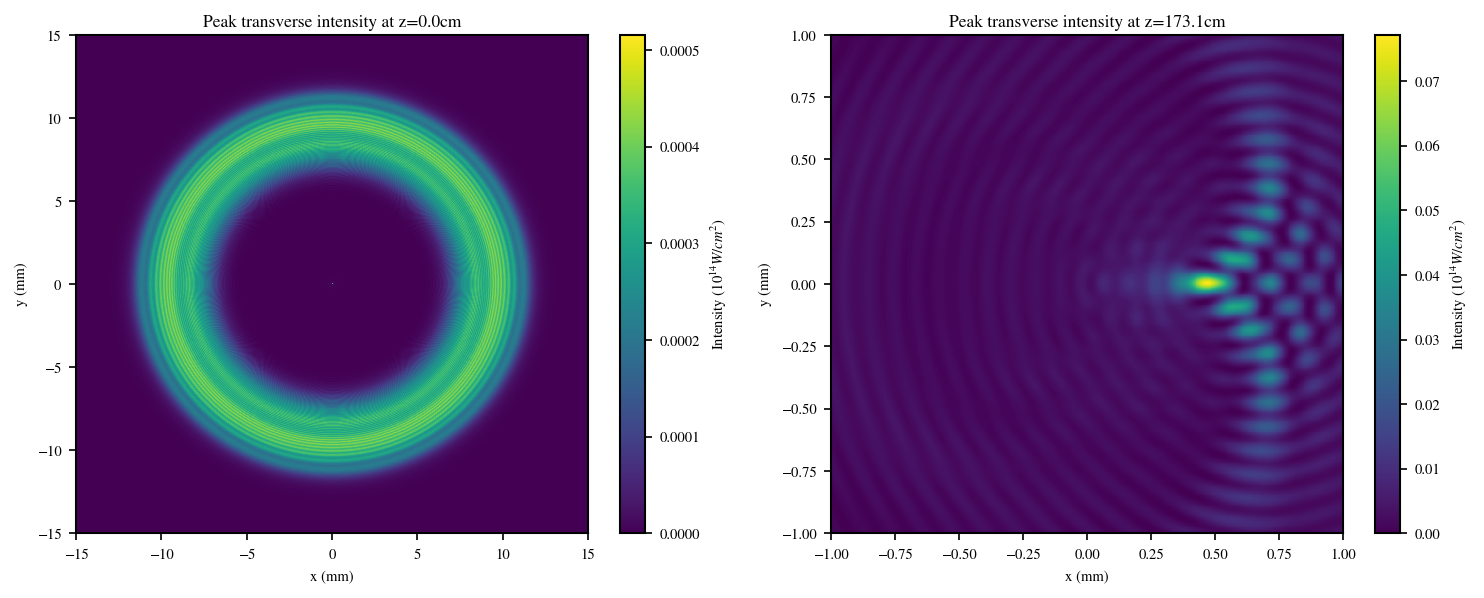

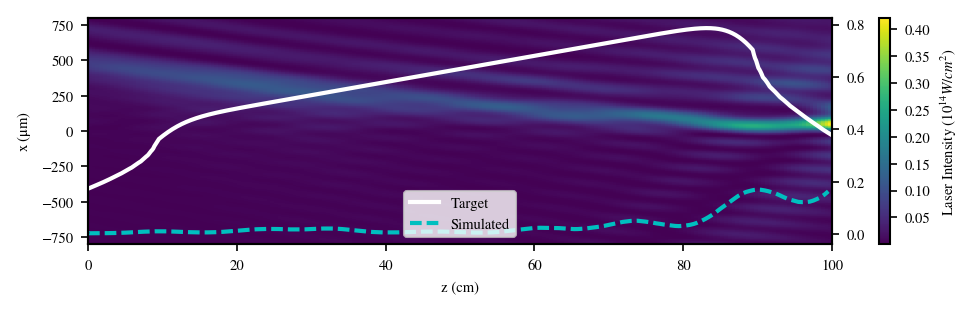

In [14]:
I_0 = get_intensity(100);

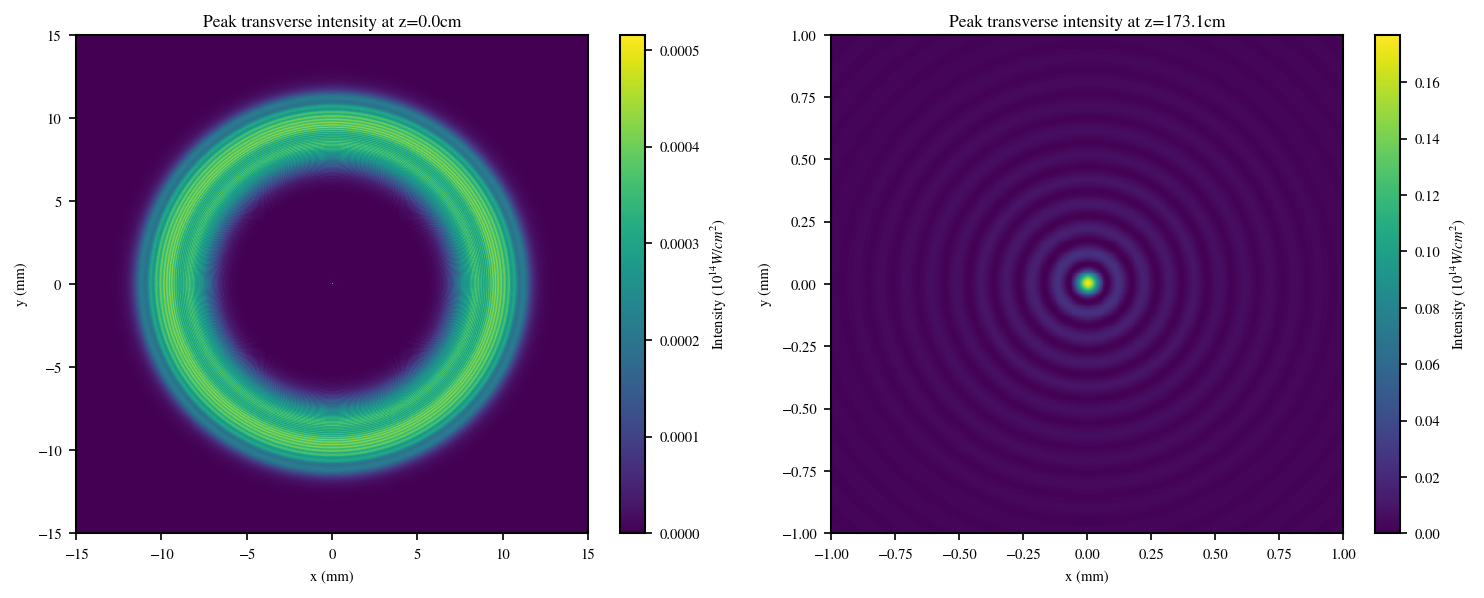

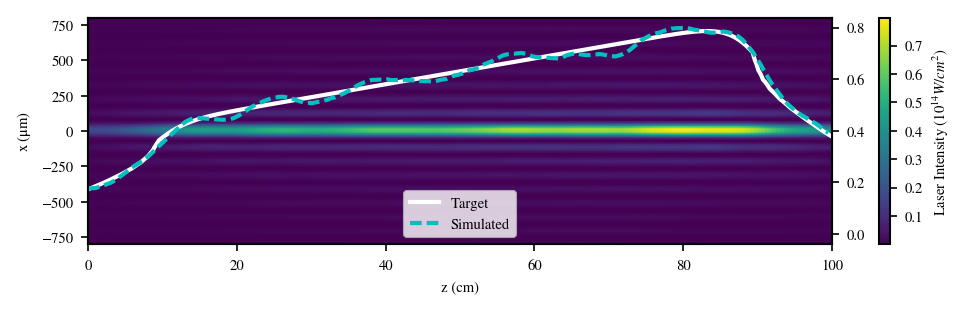

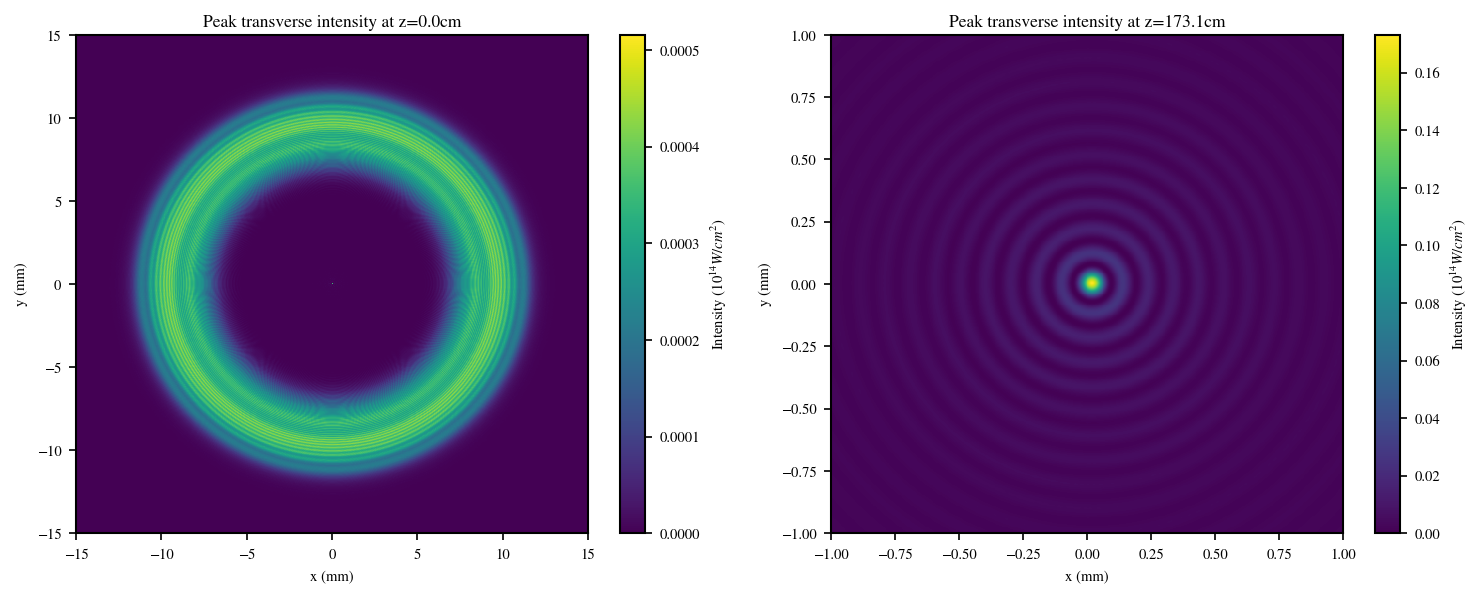

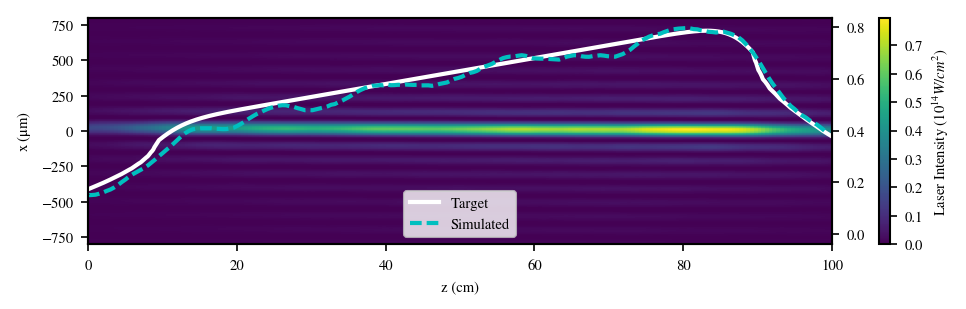

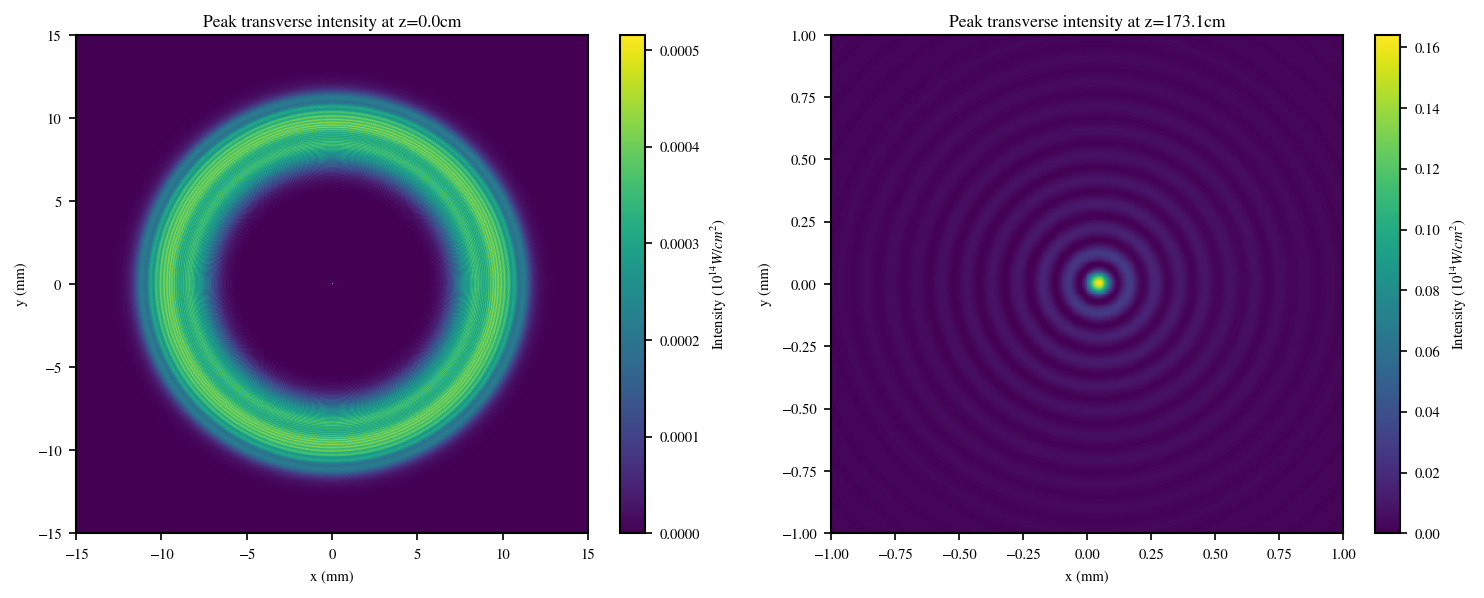

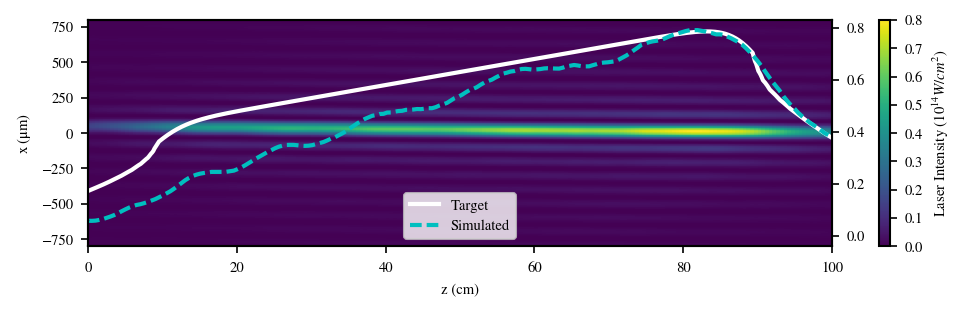

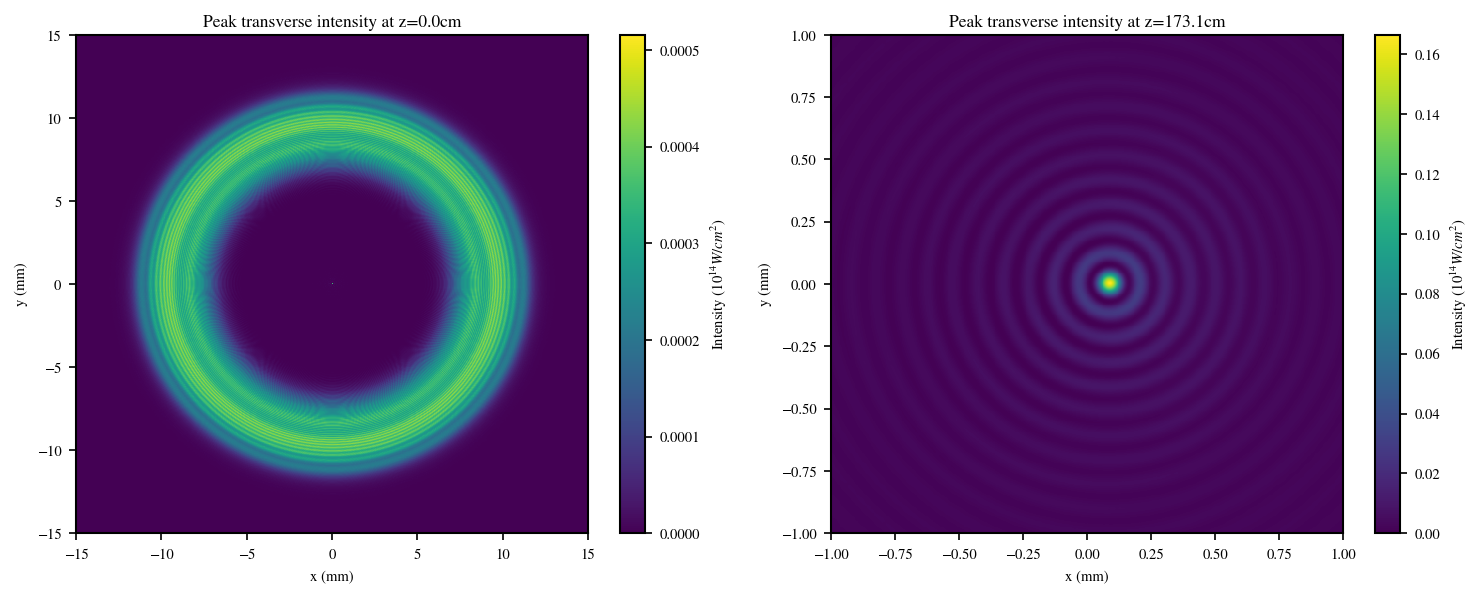

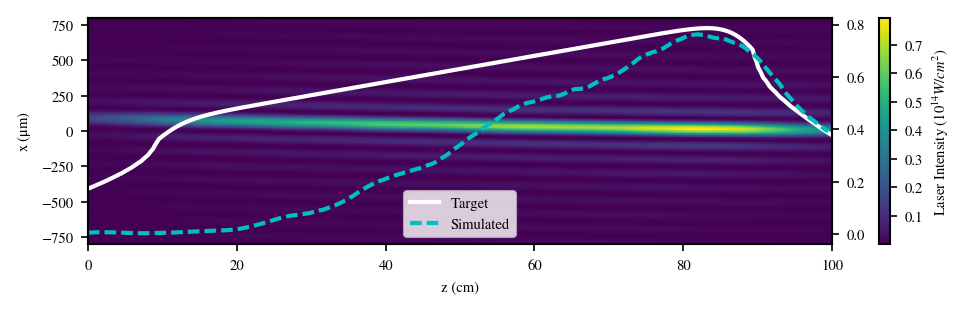

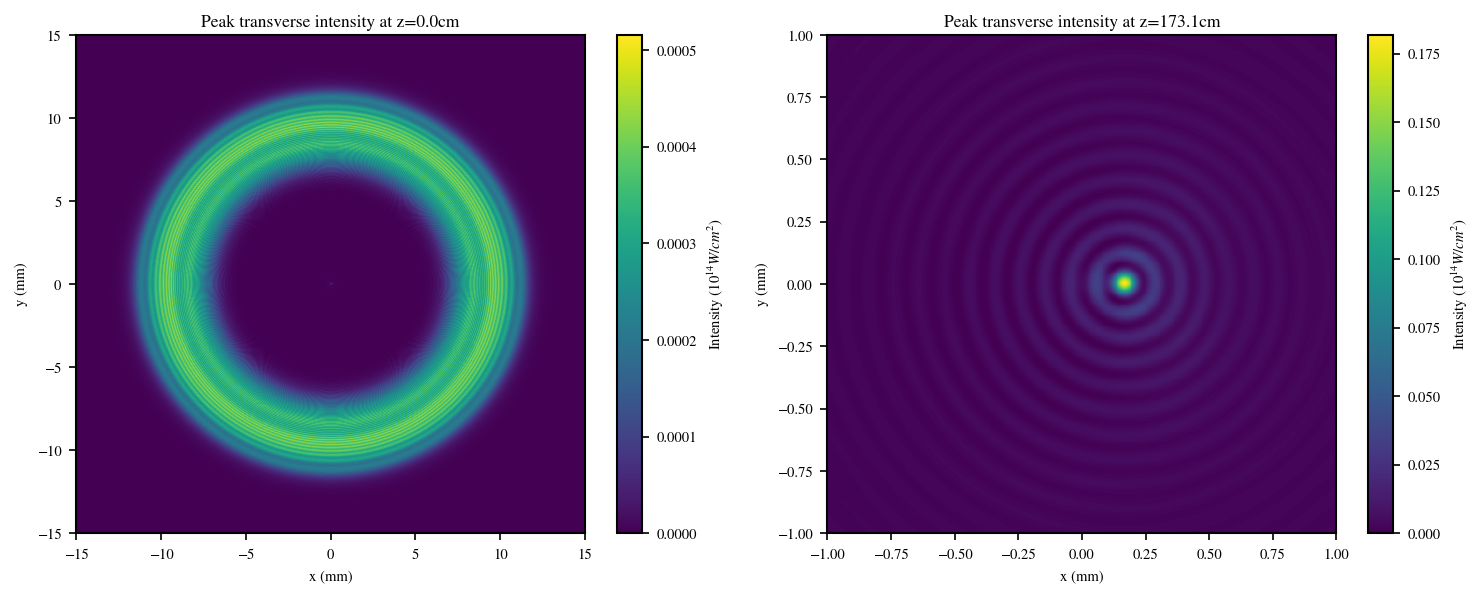

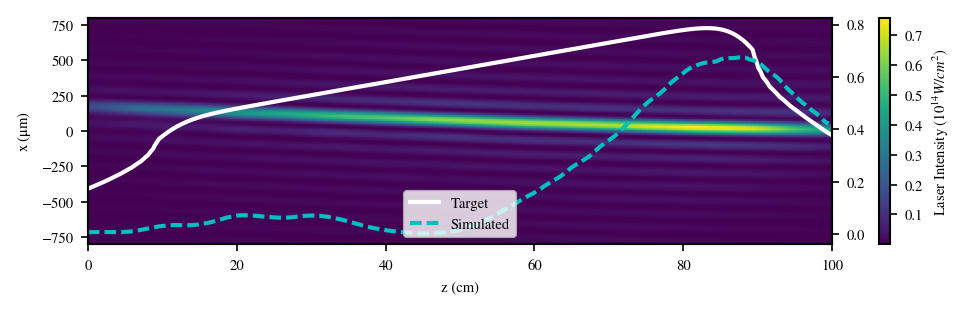

In [15]:
dx = np.array([0, 2, 5, 10, 20])
I_dx = np.zeros((len(dx), Nz, 2**11))
for i in range(len(dx)):
    I_dx[i, :, :] = get_intensity(dx[i])

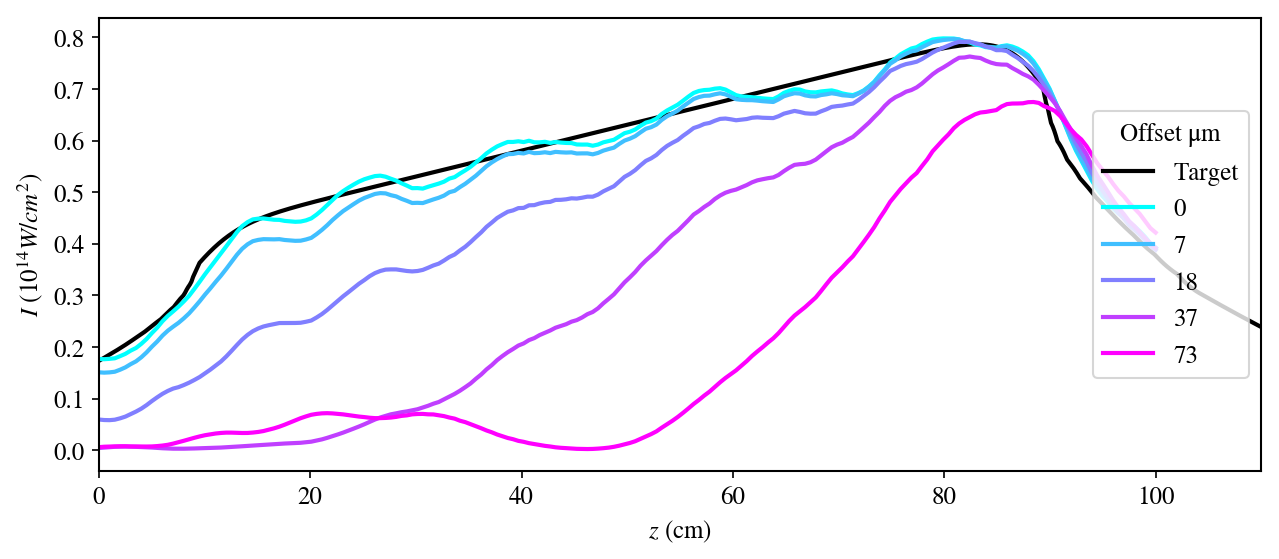

In [16]:
plt.style.use('presentation')
z = np.linspace(0, Z, Nz)
dz = z[1]-z[0]
start = z0-10e4
plt.figure(figsize=(10, 4), dpi=150)
colors = [plt.cm.cool(i) for i in np.linspace(0, 1, len(dx))]
ax = plt.subplot()
ax.set_prop_cycle('color', colors)
plt.xlabel(r'$z$ (cm)')
plt.ylabel(r'$I$ ($10^{14} W/cm^2$)')
plt.plot((z_optic-start-dz)/1e4, I_optic, 'k-', label='Target')
for i in range(len(dx)):
    plt.plot(z/1e4, I_dx[i, :, int(Nx/2)], label='%0.0f'%(dx[i]*3.66))
plt.legend(loc=7, title=r'Offset $\mathrm{\mu m}$')
plt.xlim(0, Z/1e4+10)
plt.show()

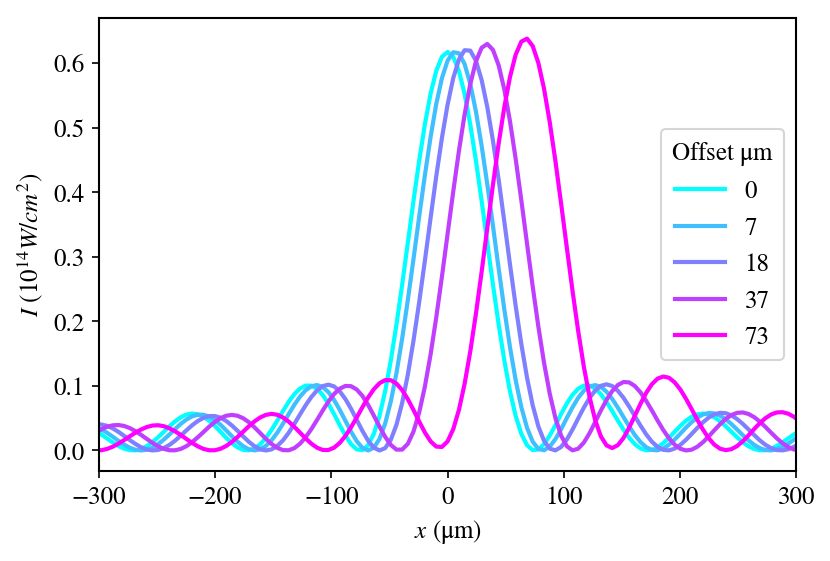

In [17]:
plt.figure(figsize=(6, 4), dpi=150)
colors = [plt.cm.cool(i) for i in np.linspace(0, 1, len(dx))]
x = np.linspace(-X/2, X/2, Nx, endpoint=False)
ax = plt.subplot()
ax.set_prop_cycle('color', colors)
plt.xlabel(r'$x$ ($\mathrm{\mu m}$)')
plt.ylabel(r'$I$ ($10^{14} W/cm^2$)')
for i in range(len(dx)):
    plt.plot(x, I_dx[i, int(Nz/2), :], label='%0.0f'%(dx[i]*3.66))
plt.legend(loc=7, title=r'Offset $\mathrm{\mu m}$')
plt.xlim(-300, 300)
plt.show()
plt.style.use('notes')

In [18]:
I_bl = design.propagate_down_beampipe(pulse, [0.8548e6, 1.2e6, 2e6], [4e3, 5e3, 20e3], 20e3, 2**10, 400)

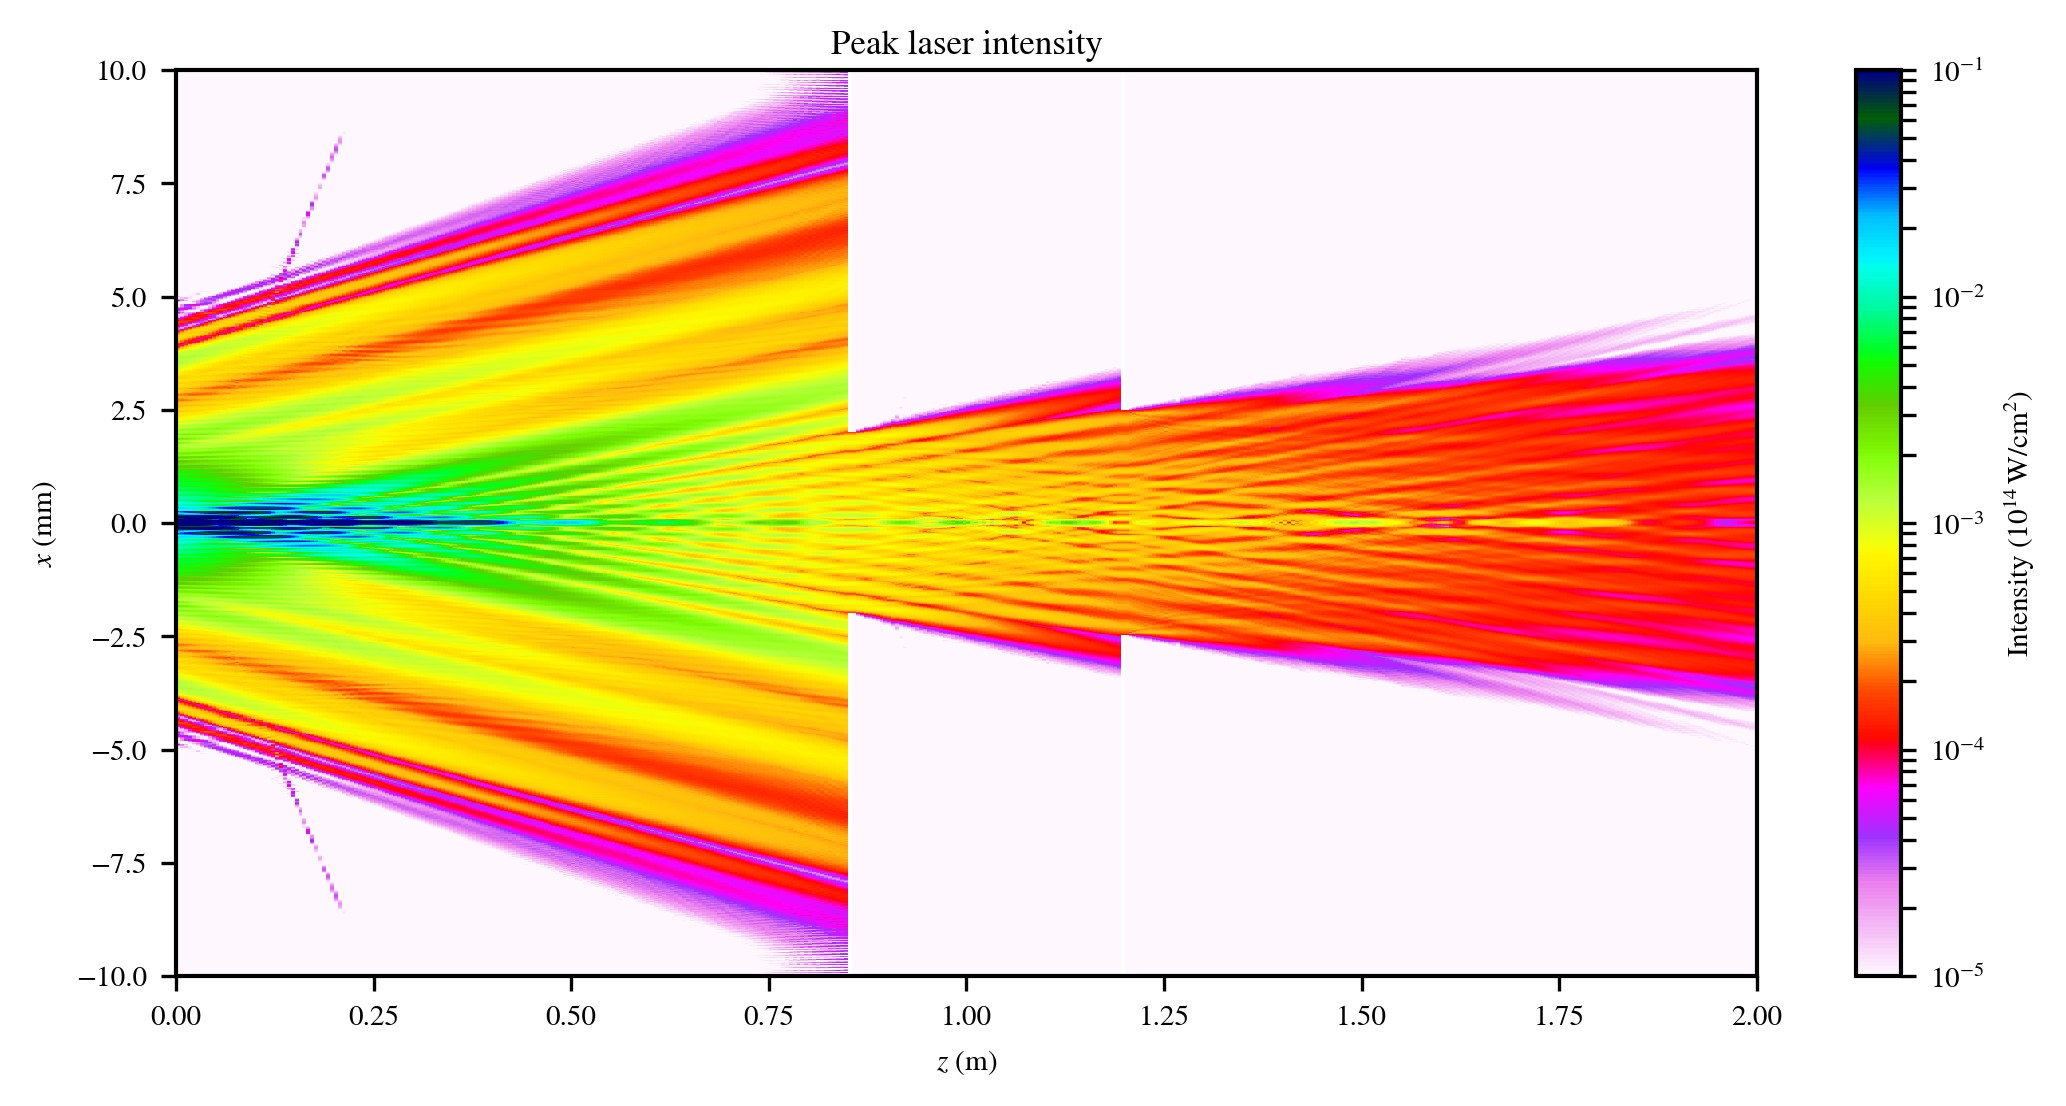

In [19]:
Z = 2e6
X = 20e3
import matplotlib.colors as colors
plt.figure(figsize=(8.5, 4), dpi=300)
norm = colors.LogNorm(vmin=1e-5, vmax=0.1)
im = plt.imshow(I_bl, aspect='auto', extent=[0, Z/1e6, -X/2e3, X/2e3], norm=norm)
cb = plt.colorbar()
cb.set_label(r'Intensity ($10^{14}\,\mathrm{W/cm^2}$)')
plt.set_cmap('gist_ncar_r')
plt.xlabel(r'$z$ (m)')
plt.ylabel(r'$x$ (mm)')
plt.title('Peak laser intensity')
plt.show()

In [20]:
# First Optic A to Optic B
XA = lensA.X
NxA = lensA.Nx
beamParams = {'Nx' : NxA,
              'Ny' : NxA,
              'X' : XA,
              'Y' : XA,
              'lam' : lam,
              'path' : path,
              'name' : 'Beam0_A_to_B',
              'threads' : 20,
              'cyl' : True,
              'load' : False}

# Super Gaussian for simulation
Nz0 = 400
z_ab = np.linspace(0, L, Nz0)
beam = laserbeam.Laser(beamParams)
e = beam.reconstruct_from_cyl(r0, E0, beam.x, beam.y)
beam.initialize_field(e)
I0 = ionization.intensity_from_field(E0)
print('Total input energy %0.2fmJ' % (beam.total_cyl_power(r0, I0)*tau))
interactions.beam_phase(beam, lensA)
beam.propagate(z_ab, 1.0)

Total input energy 17.74mJ


In [21]:
I_ab = np.zeros((Nz0, NxA))
for i in range(Nz0):
    I_ab[i, :] = beam.intensity_from_field(beam.load_field(i+1)[0])
I_ab = beam.prep_data(I_ab)

In [22]:
XB = 30e3
NxB = 2**13
pulseParams = {
    'Nt' : 2**6,
    'Nx' : NxB,
    'Ny' : NxB,
    'X' : XB,
    'Y' : XB,
    'T' : 3*tau,
    'lam' : lam,
    'path' : path,
    'load' : False,
    'threads' : 20,
    'cyl' : True,
    'tau' : tau,
    'name' : 'To_Start',
}
Z1 = z0
beam = laserbeam.Laser(pulseParams)
e = beam.reconstruct_from_cyl(r1, e1, beam.x, beam.y)
beam.initialize_field(e)
Nz1 = 400
z_bLO = np.linspace(0, Z1, Nz1)
beam.propagate(z_bLO, 1)

In [23]:
I_bLO = np.zeros((Nz1, NxB))
for i in range(Nz1):
    I_bLO[i, :] = beam.intensity_from_field(beam.load_field(i)[0])
I_bLO = beam.prep_data(I_bLO)

In [25]:
XP = 10e3
NxP = 2**11
NzP = 400
Z_p = 80e4
ne0 = 3.4e16/1e17
z = np.linspace(0, Z_p, 5000)
sim_start, n_plot, n = profile.lithium_oven_profile(z, 40e4, ne0)
#plt.style.use('presentation')
pulse2, I, ne = design.plasma_refraction(XP, NxP, Z_p, NzP, beam, pulseParams, ionization.Li, n, sim_start, 1,
                                        ne0, name='Plasma')

KeyboardInterrupt: 

In [ ]:
ext = [0, Z_p/1e4, -XP/2, XP/2]
design.plot_plasma_density(pulse2, ne, ne0, ext, lines=[20, 40, 60])

In [ ]:
I_p = np.zeros((NzP, NxP))
for i in range(NzP):
    I_p[i, :] = np.amax(pulse2.intensity_from_field(pulse2.load_field(i)[0]), axis=0)
I_p = pulse2.prep_data(I_p)

In [ ]:
NxD = 2**11
XD = 20e3
NzD = 400
ZD = 2e6
I_D = design.propagate_down_beampipe(pulse2, [0.8548e6, 1.2e6, ZD], [4e3, 5e3, 20e3], XD, NxD, NzD)

In [ ]:
import numpy.ma as ma
from copy import copy
def prep_ma(Z, X, Nzi, Zi, Z0i, Xi, Nxi, array):
    
    # Calculate the size of the extended array
    Nx = int(Nxi*X/Xi)
    Nz = int(Nzi*Z/Zi)
    # Extend the array to fill the entire imshow with the correct spacing
    Im = np.zeros((Nx, Nz))
    Im = ma.asarray(Im)
    # Mark the entire array as invalid
    Im[:, :] = ma.masked
    # Fill in the intensity 
    Nx0 = int((Nx-Nxi)/2)
    Nz0 = int(Nzi*Z0i/Zi)
    Im[Nx0:Nx0+Nxi, Nz0:Nz0+Nzi] = array
    return Im

In [ ]:
Z = L+Z1+Z_p+ZD
X = XA
ext0 = [0, Z/1e3, -X/2e3, X/2e3]
I0m = prep_ma(Z, X, Nz0, L, 0.0, XA, NxA, I_ab)
I1m = prep_ma(Z, X, Nz1, Z1, L, XB, NxB, I_bLO)
I2m = prep_ma(Z, X, NzP, Z_p, L+Z1, XP, NxP, I_p)
I3m = prep_ma(Z, X, NzD, ZD, L+Z1+Z_p, XD, NxD, I_D)

In [ ]:
plt.figure(figsize=(8.5, 4), dpi=300)
palette = copy(plt.cm.gist_ncar_r)
palette.set_bad('w', 0.0)
palette.set_under('w', 1.0)
norm = colors.LogNorm(vmin=1e9, vmax=5e13)
#im = plt.imshow(I_ab, aspect='auto', extent=ext0, norm=norm)
plt.imshow(I0m*1e14, aspect='auto', extent=ext0, norm=norm)
plt.imshow(I1m*1e14, aspect='auto', extent=ext0, norm=norm)
plt.imshow(I2m*1e14, aspect='auto', extent=ext0, norm=norm)
plt.imshow(I3m*1e14, aspect='auto', extent=ext0, norm=norm)
cb = plt.colorbar()
cb.set_label(r'Intensity ($\mathrm{W/cm^2}$)')
plt.set_cmap(palette)
plt.xlabel(r'$z$ (mm)')
plt.ylabel(r'$x$ (mm)')
plt.title('Peak laser intensity')
plt.ylim(-15, 15)

# Optic A and Optic B
plt.plot([0, 0], [-15, 15], 'b-', lw=1)
plt.plot([L/1e3, L/1e3], [-15, 15], 'b-', lw=1)
# USHM
dz = 401
plt.plot([L/1e3+dz, L/1e3+dz], [-25.4, -2.5], 'k-', lw=1)
plt.plot([L/1e3+dz, L/1e3+dz], [25.4, 2.5], 'k-', lw=1)
plt.text(1250, 12, 'USHM')
# LO pipe
dz = 1424.6
l = 1695.5
plt.plot([L/1e3+dz, L/1e3+dz], [-25.4, -14.3], 'k-', lw=1)
plt.plot([L/1e3+dz, L/1e3+dz], [25.4, 14.3], 'k-', lw=1)
plt.plot([L/1e3+dz, L/1e3+dz+l], [-14.3, -14.3], 'k-', lw=1)
plt.plot([L/1e3+dz, L/1e3+dz+l], [14.3, 14.3], 'k-', lw=1)
plt.plot([L/1e3+dz+l, L/1e3+dz+l], [-25.4, -14.3], 'k-', lw=1)
plt.plot([L/1e3+dz+l, L/1e3+dz+l], [25.4, 14.3], 'k-', lw=1)
plt.text(2800, -13.5, 'Lithium Oven Pipe')
# DSHM
p_end = L/1e3+z0/1e3+800
dz = p_end+854.8
plt.plot([dz, dz], [-25.4, -2], 'k-', lw=1)
plt.plot([dz, dz], [25.4, 2], 'k-', lw=1)
plt.text(4000, 9, 'DSHM')
# Plasma
#plt.plot([p_end-800, p_end], [-10, -10], 'k-', lw=1)
# Differential Pumping
dz = p_end+1200
l = 100
plt.plot([dz, dz], [-25.4, -2.5], 'k-', lw=1)
plt.plot([dz, dz], [25.4, 2.5], 'k-', lw=1)
plt.plot([dz, dz+l], [-2.5, -2.5], 'k-', lw=1)
plt.plot([dz, dz+l], [2.5, 2.5], 'k-', lw=1)
plt.plot([dz+l, dz+l], [-25.4, -2.5], 'k-', lw=1)
plt.plot([dz+l, dz+l], [25.4, 2.5], 'k-', lw=1)

#plt.plot([p_end-400])
plt.tight_layout()
plt.show()

In [ ]:
fig = plt.figure(figsize=(10, 3), dpi=150)
ne_im = np.flipud(np.transpose(ne/1e16))
ext = [0, Z_p/1e4, -XP/2, XP/2]
im = plt.imshow(ne_im, aspect='auto', extent=ext, cmap='plasma',
                interpolation='Spline16')
plt.ylabel(r'$x$ ($\mathrm{\mu m}$)')
plt.ylim(-500, 500)
cb = plt.colorbar(im)
cb.set_label(r'$n_e$ ($10^{16}\mathrm{cm^{-3}}$)')

dx = pulse2.x[1]-pulse2.x[0]
plt.contour(np.array(pulse2.z)/1e4, pulse2.x+dx, I_p, [0.0338, 0.065, 0.1] )
#plt.colorbar()
plt.show()

Total input energy 17.74mJ
Initial pulse energy 8.58mJ
Final pulse energy 8.58mJ


/home/robert/anaconda3/envs/CU-PWFA/lib/python3.6/site-packages/matplotlib/axes/_base.py:2899: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0.0
  'left=%s, right=%s') % (left, right))


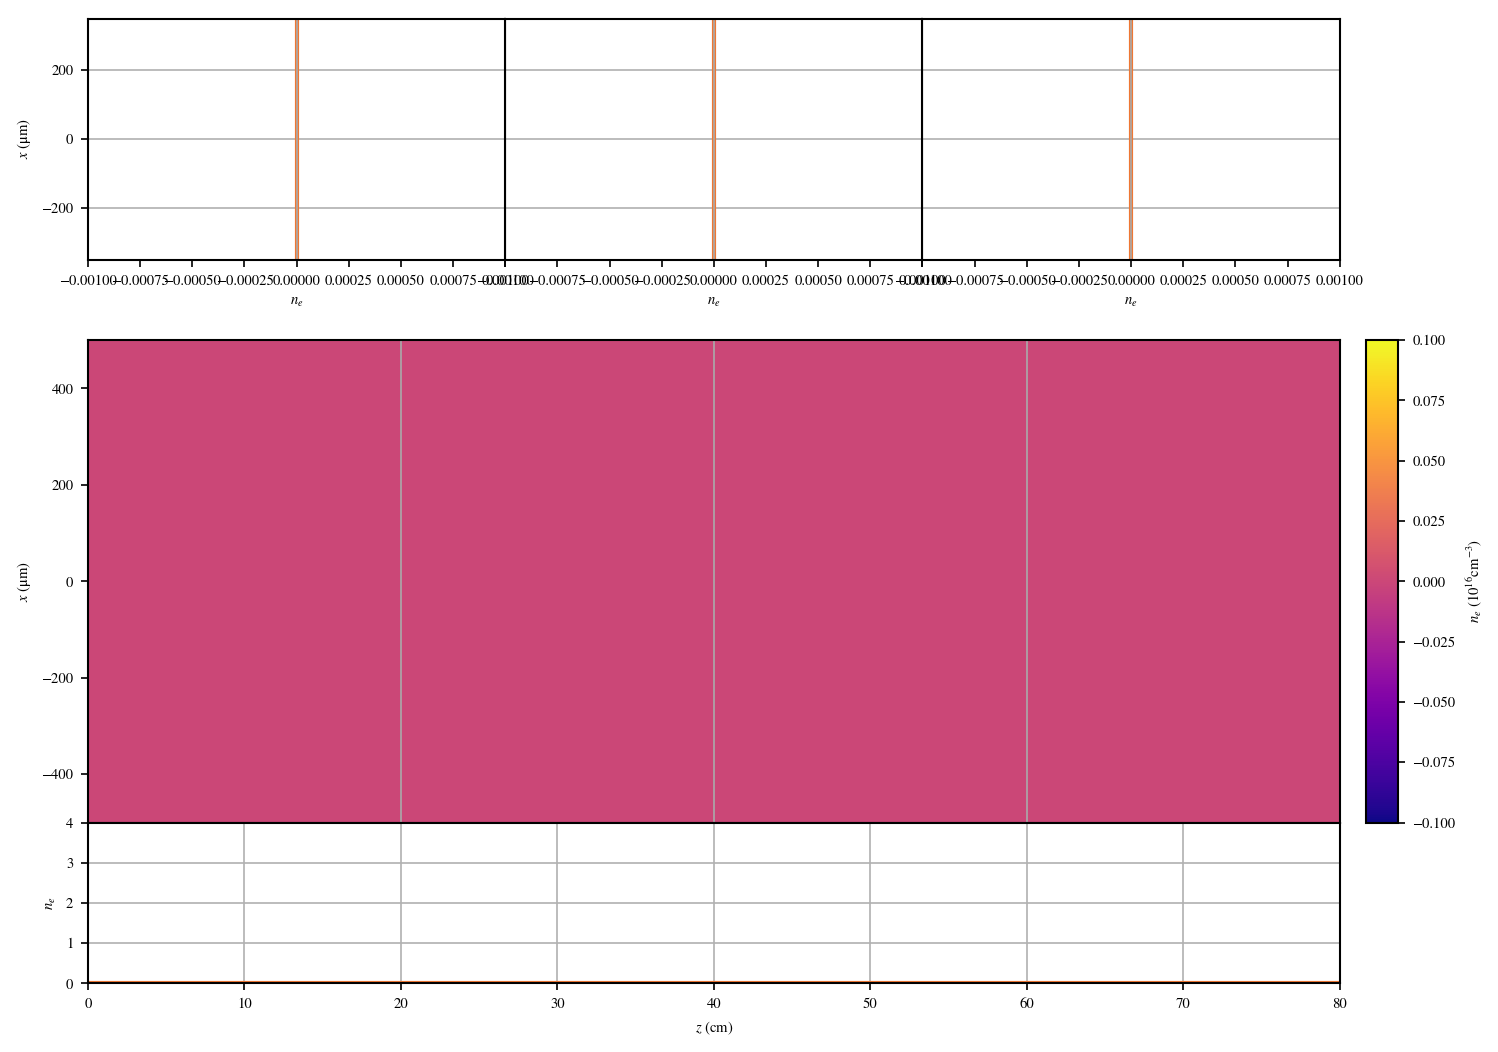

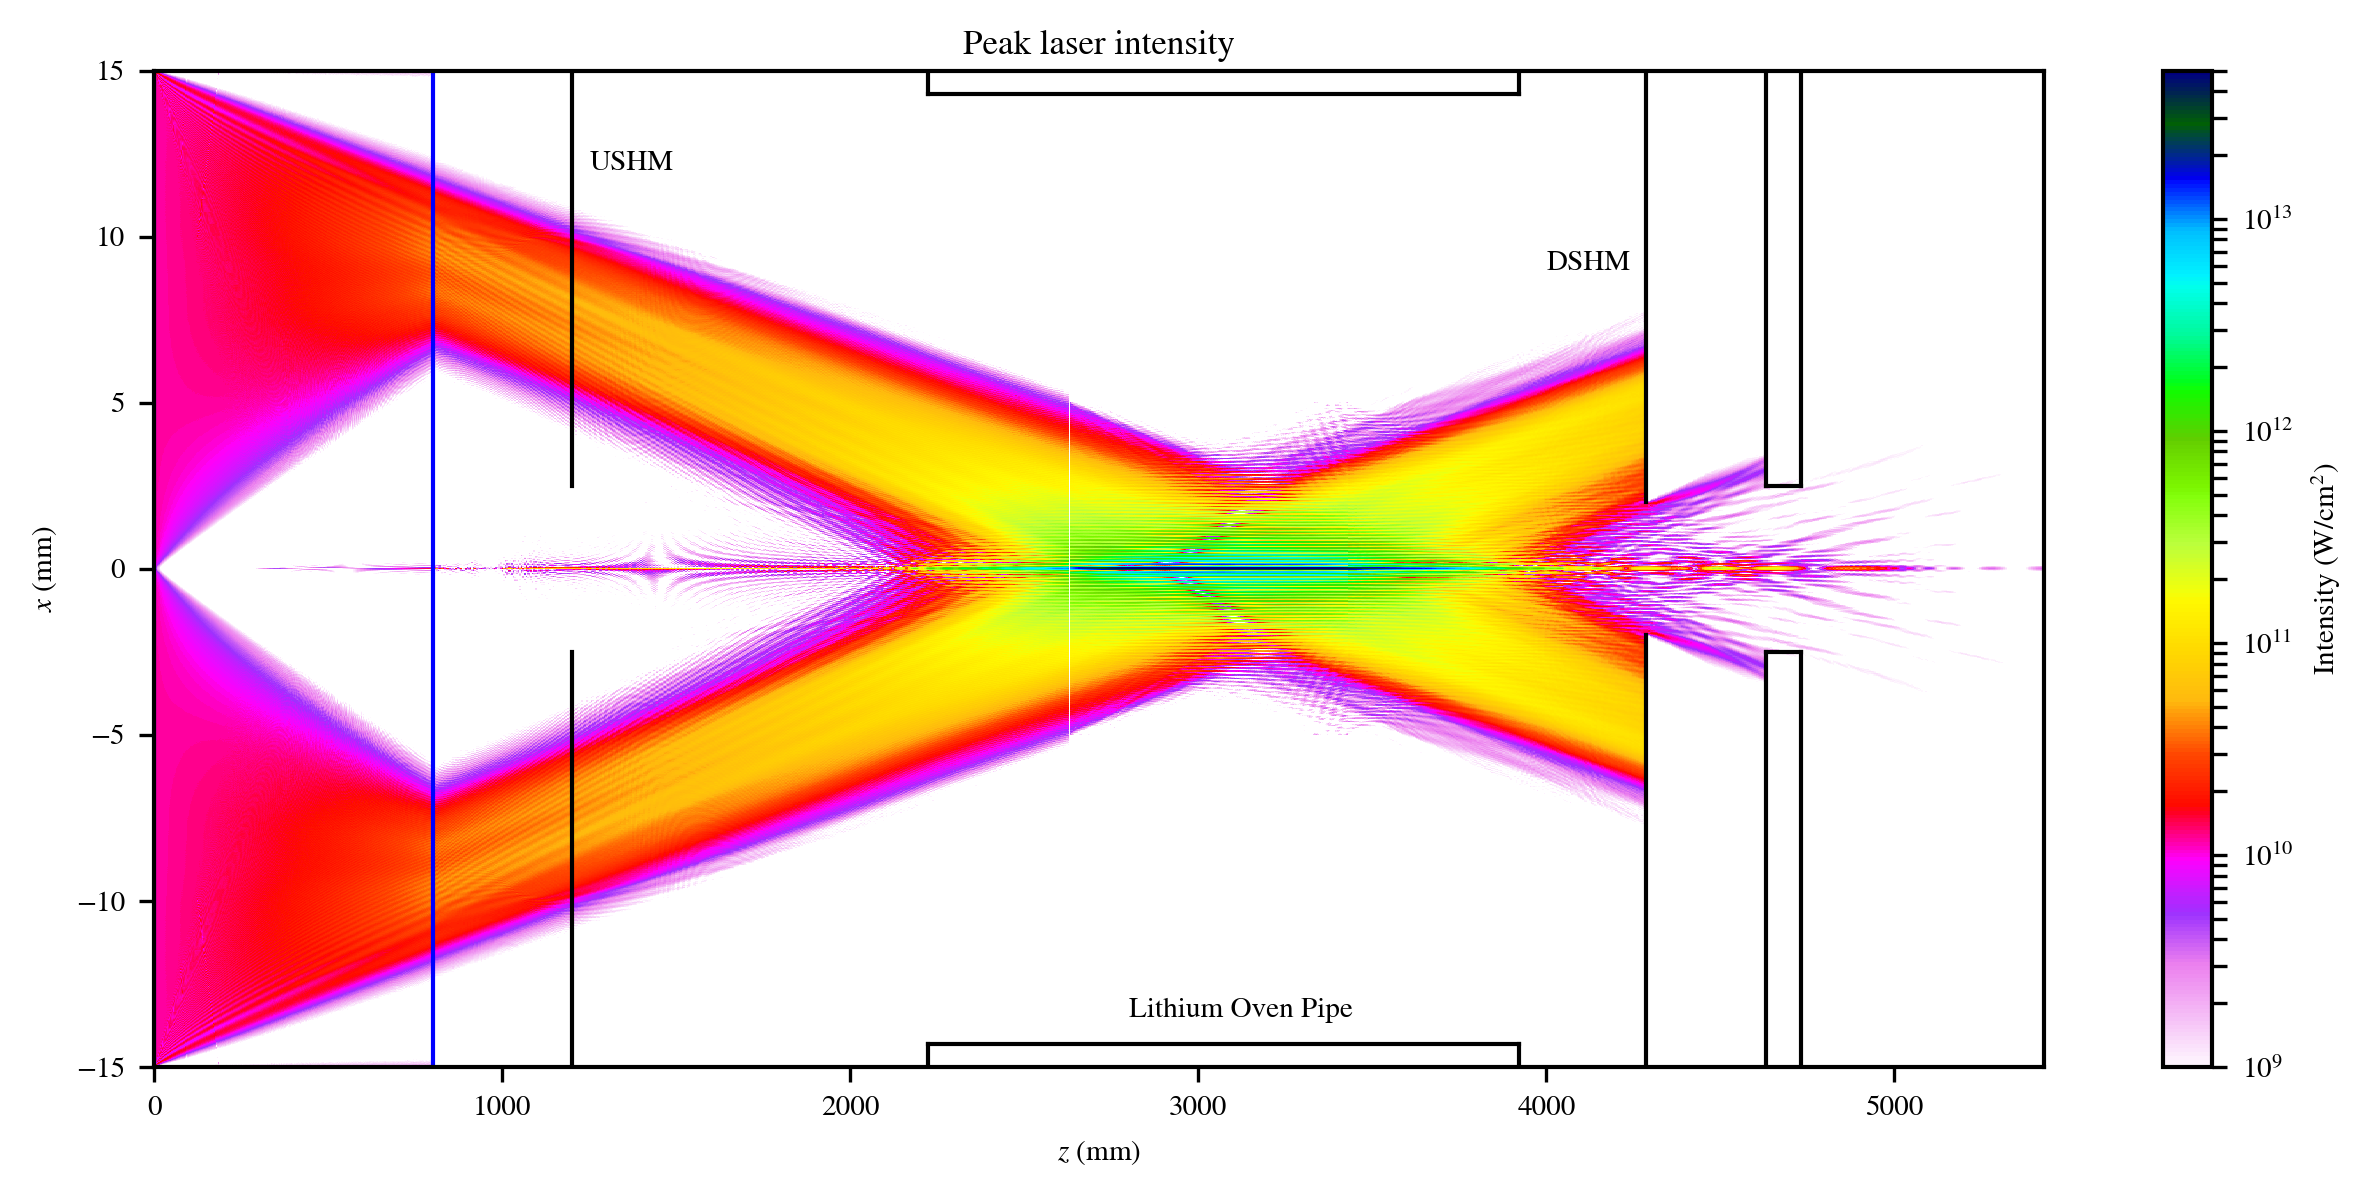

In [26]:
# First Optic A to Optic B
XA = lensA.X
NxA = lensA.Nx
beamParams = {'Nx' : NxA,
              'Ny' : NxA,
              'X' : XA,
              'Y' : XA,
              'lam' : lam,
              'path' : path,
              'name' : 'Beam0_A_to_B',
              'threads' : 20,
              'cyl' : True,
              'load' : False}

# Super Gaussian for simulation
Nz0 = 400
z_ab = np.linspace(0, L, Nz0)
beam = laserbeam.Laser(beamParams)
e = beam.reconstruct_from_cyl(r0, E0, beam.x, beam.y)
beam.initialize_field(e)
I0 = ionization.intensity_from_field(E0)
print('Total input energy %0.2fmJ' % (beam.total_cyl_power(r0, I0)*tau))
interactions.beam_phase(beam, lensA)
beam.propagate(z_ab, 1.0)

I_ab = np.zeros((Nz0, NxA))
for i in range(Nz0):
    I_ab[i, :] = beam.intensity_from_field(beam.load_field(i+1)[0])
I_ab = beam.prep_data(I_ab)

XB = 30e3
NxB = 2**13
pulseParams = {
    'Nt' : 2**6,
    'Nx' : NxB,
    'Ny' : NxB,
    'X' : XB,
    'Y' : XB,
    'T' : 3*tau,
    'lam' : lam,
    'path' : path,
    'load' : False,
    'threads' : 20,
    'cyl' : True,
    'tau' : tau,
    'name' : 'To_Start',
}
Z1 = z0
beam = laserbeam.Laser(pulseParams)
e = beam.reconstruct_from_cyl(r1, e1, beam.x, beam.y)
beam.initialize_field(e)
Nz1 = 400
z_bLO = np.linspace(0, Z1, Nz1)
beam.propagate(z_bLO, 1)

I_bLO = np.zeros((Nz1, NxB))
for i in range(Nz1):
    I_bLO[i, :] = beam.intensity_from_field(beam.load_field(i)[0])
I_bLO = beam.prep_data(I_bLO)

XP = 10e3
NxP = 2**11
NzP = 400
Z_p = 80e4
ne0 = 0.0
z = np.linspace(0, Z_p, 5000)
sim_start, n_plot, n = profile.lithium_oven_profile(z, 40e4, ne0)
#plt.style.use('presentation')
pulseParams['Nt'] = 2
pulse2, I, ne = design.plasma_refraction(XP, NxP, Z_p, NzP, beam, pulseParams, ionization.Li, n, sim_start, 1,
                                        ne0, name='Plasma')

ext = [0, Z_p/1e4, -XP/2, XP/2]

I_p = np.zeros((NzP, NxP))
for i in range(NzP):
    I_p[i, :] = np.amax(pulse2.intensity_from_field(pulse2.load_field(i)[0]), axis=0)
I_p = pulse2.prep_data(I_p)

NxD = 2**11
XD = 20e3
NzD = 400
ZD = 2e6
I_D = design.propagate_down_beampipe(pulse2, [0.8548e6, 1.2e6, ZD], [4e3, 5e3, 20e3], XD, NxD, NzD)

import numpy.ma as ma
from copy import copy
def prep_ma(Z, X, Nzi, Zi, Z0i, Xi, Nxi, array):
    
    # Calculate the size of the extended array
    Nx = int(Nxi*X/Xi)
    Nz = int(Nzi*Z/Zi)
    # Extend the array to fill the entire imshow with the correct spacing
    Im = np.zeros((Nx, Nz))
    Im = ma.asarray(Im)
    # Mark the entire array as invalid
    Im[:, :] = ma.masked
    # Fill in the intensity 
    Nx0 = int((Nx-Nxi)/2)
    Nz0 = int(Nzi*Z0i/Zi)
    Im[Nx0:Nx0+Nxi, Nz0:Nz0+Nzi] = array
    return Im

Z = L+Z1+Z_p+ZD
X = XA
ext0 = [0, Z/1e3, -X/2e3, X/2e3]
I0m = prep_ma(Z, X, Nz0, L, 0.0, XA, NxA, I_ab)
I1m = prep_ma(Z, X, Nz1, Z1, L, XB, NxB, I_bLO)
I2m = prep_ma(Z, X, NzP, Z_p, L+Z1, XP, NxP, I_p)
I3m = prep_ma(Z, X, NzD, ZD, L+Z1+Z_p, XD, NxD, I_D)

In [ ]:
plt.figure(figsize=(8.5, 4), dpi=300)
palette = copy(plt.cm.gist_ncar_r)
palette.set_bad('w', 0.0)
palette.set_under('w', 1.0)
norm = colors.LogNorm(vmin=1e9, vmax=5e13)
im = plt.imshow(I_ab, aspect='auto', extent=ext0, norm=norm)
plt.imshow(I0m*1e14, aspect='auto', extent=ext0, norm=norm)
plt.imshow(I1m*1e14, aspect='auto', extent=ext0, norm=norm)
plt.imshow(I2m*1e14, aspect='auto', extent=ext0, norm=norm)
plt.imshow(I3m*1e14, aspect='auto', extent=ext0, norm=norm)
cb = plt.colorbar()
cb.set_label(r'Intensity ($\mathrm{W/cm^2}$)')
plt.set_cmap(palette)
plt.xlabel(r'$z$ (mm)')
plt.ylabel(r'$x$ (mm)')
plt.title('Peak laser intensity')
plt.ylim(-15, 15)

# Optic A and Optic B
plt.plot([0, 0], [-15, 15], 'b-', lw=1)
plt.plot([L/1e3, L/1e3], [-15, 15], 'b-', lw=1)
# USHM
dz = 401
plt.plot([L/1e3+dz, L/1e3+dz], [-25.4, -2.5], 'k-', lw=1)
plt.plot([L/1e3+dz, L/1e3+dz], [25.4, 2.5], 'k-', lw=1)
plt.text(1250, 12, 'USHM')
# LO pipe
dz = 1424.6
l = 1695.5
plt.plot([L/1e3+dz, L/1e3+dz], [-25.4, -14.3], 'k-', lw=1)
plt.plot([L/1e3+dz, L/1e3+dz], [25.4, 14.3], 'k-', lw=1)
plt.plot([L/1e3+dz, L/1e3+dz+l], [-14.3, -14.3], 'k-', lw=1)
plt.plot([L/1e3+dz, L/1e3+dz+l], [14.3, 14.3], 'k-', lw=1)
plt.plot([L/1e3+dz+l, L/1e3+dz+l], [-25.4, -14.3], 'k-', lw=1)
plt.plot([L/1e3+dz+l, L/1e3+dz+l], [25.4, 14.3], 'k-', lw=1)
plt.text(2800, -13.5, 'Lithium Oven Pipe')
# DSHM
p_end = L/1e3+z0/1e3+800
dz = p_end+854.8
plt.plot([dz, dz], [-25.4, -2], 'k-', lw=1)
plt.plot([dz, dz], [25.4, 2], 'k-', lw=1)
plt.text(4000, 9, 'DSHM')
# Plasma
#plt.plot([p_end-800, p_end], [-10, -10], 'k-', lw=1)
# Differential Pumping
dz = p_end+1200
l = 100
plt.plot([dz, dz], [-25.4, -2.5], 'k-', lw=1)
plt.plot([dz, dz], [25.4, 2.5], 'k-', lw=1)
plt.plot([dz, dz+l], [-2.5, -2.5], 'k-', lw=1)
plt.plot([dz, dz+l], [2.5, 2.5], 'k-', lw=1)
plt.plot([dz+l, dz+l], [-25.4, -2.5], 'k-', lw=1)
plt.plot([dz+l, dz+l], [25.4, 2.5], 'k-', lw=1)

#plt.plot([p_end-400])
plt.tight_layout()
plt.show()